In [31]:
import torch
# 全局设置设备为 GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
from torch.nn import Conv1d

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.metrics import classification_report, precision_score, recall_score, fbeta_score, accuracy_score, roc_auc_score, matthews_corrcoef
from sklearn.preprocessing import MinMaxScaler, StandardScaler
standard_scaler = StandardScaler()

import seaborn as sns

import glob

# 假设 get_tg_bert 是一个函数，用于获取预加载的 BERT 结果
#from get_tg_token import get_tg_bert
# 平台环境运行不了 tensorflow 无法调用，调用预加载的 bert 结果
from protein_bert_pre import load_bert as get_tg_bert

In [32]:
#靶点序列
target_seq_pth={
    'CHEMBL1811':'P34995.fasta',
    'CHEMBL1974':'P36888.fasta',
    'CHEMBL1985':'P47871.fasta',
    'CHEMBL4896':'Q96KB5.fasta'
    }

In [33]:
#获得真实数据用于对比准确
def get_true_labels(test_loader):
    true_labels = []
    # 遍历测试数据加载器
    for batch_id, (inputs, labels ,grah,gh1,gh2) in enumerate(test_loader):
        # 将标签添加到列表中
        true_labels.append(labels)  # 不需要转换为 numpy 数组
    # 将列表中的 Tensor 合并为一个单一的张量
    true_labels = torch.cat(true_labels, dim=0)
    true_labels = true_labels.float()  # 转换为浮点数类型
    # 应用 softmax 函数
    #true_labels = F.softmax(true_labels, dim=1)
    # 转化为 numpy 数组
    true_labels = true_labels.cpu().numpy()  # 确保张量在 CPU 上
    #true_labels = true_labels[:, 1]
    # 输出结果
    return true_labels

In [34]:
#图数据增强
# 随机丢弃边函数
def drop_edge(edge_index, p):
    """
    随机丢弃边
    :param edge_index: 边索引，形状为 [2, num_edges]
    :param p: 丢弃边的概率
    :return: 处理后的边索引
    """
    num_edges = edge_index.size(1)
    # 生成一个布尔掩码，用于决定哪些边要保留
    mask = torch.rand(num_edges) > p
    return edge_index[:, mask]

# 原子特征掩码函数
def mask_node(x, p):
    """
    原子特征掩码
    :param x: 节点特征矩阵，形状为 [num_nodes, num_features]
    :param p: 掩盖节点特征的概率
    :return: 处理后的节点特征矩阵，以及掩码向量
    """
    num_nodes = x.size(0)
    # 生成一个布尔掩码，用于决定哪些节点的特征要被掩盖
    mask = torch.rand(num_nodes) < p
    masked_x = x.clone()
    feature_mean = torch.mean(x, dim=0)
    # 将被掩盖节点的特征替换为平均值
    masked_x[mask] = feature_mean
    #masked_x[mask] = 0  # 用全零向量替换被掩盖节点的特征
    return masked_x, mask



In [35]:
# 数据集加载
from def_GNN import smiles_to_graph
from torch.utils.data import Dataset 
class Train_C_Data(Dataset):
    def __init__(self, filepath):
        # 导入数据
        self.df = pd.read_csv(filepath)
        self.df['Activity'] = self.df['Activity'].map({'Active': 1, 'Inactive': 0})#活性为1，非活性为0
        df = self.df.iloc[:, 1:]
        
        # 标准化特征
        scaler = StandardScaler()
        #0是acitivate,-1 is smiles
        #print(df)
        df_x = scaler.fit_transform(df.iloc[:, 1:-1])  # 最大最小值
        df_x = pd.DataFrame(df_x)
        df_Standard = pd.concat([df.iloc[:, 0].to_frame(), df_x,], axis=1)

        #分子图处理
        smiles_to_graph
        # 使用 apply 方法处理 'smiles' 列
        df['graph'] = df.apply(smiles_to_graph,axis=1)

        # 将 dfs 列转换为 NumPy 数组
        graph_data = df['graph'].tolist()

        # 转换为 float32 类型的 NumPy 数组
        arr = df_Standard.values.astype(np.float32)

        # 转换为张量
        ts = torch.tensor(arr, dtype=torch.float32)
        # 划分特征和标签
        self.X = ts[:, 1:]  # 第 2 列及以后为输入特征,最后一列是smiles
        self.y = ts[:, 0].long()  # 第 0 列为标签，转换为 int64 类型
        #self.y = torch.nn.functional.one_hot(self.y, num_classes=2)  # 将标签转换为 one-hot 编码
        self.graph = graph_data
        # 样本总数
        self.len = ts.shape[0]
        
        # 特征数
        self.feature_size = self.X.shape[1] 
        self.date_value = self.X.shape[0] 



    def __getitem__(self, index):
        graph_data = self.graph[index]
        # 生成两个增强图版本
        self.graph1 = self.apply_graph_augmentation(graph_data)
        self.graph2 = self.apply_graph_augmentation(graph_data)
         # 返回单个样本的特征和标签
        return self.X[index], self.y[index], graph_data, self.graph1, self.graph2

    def __len__(self):
        # 返回数据集的样本总数
        return self.len
    
    @staticmethod #静态
    def apply_graph_augmentation(graph_data):
        """图数据增强函数"""
        # 随机丢弃边（概率15%）
        #print(graph_data)
        edge_index = drop_edge(graph_data.edge_index, p=0.15)
        
        # 随机掩码节点特征（概率10%）
        masked_x, _ = mask_node(graph_data.x, p=0.1)
        
        # 保持其他图结构不变
        return Data(
            x=masked_x,
            edge_index=edge_index,
            edge_attr=graph_data.edge_attr
        )

In [36]:
'''class sreen_c_data(Dataset):
    def __init__(self, filepath):
        # 导入数据
        self.df = pd.read_csv(filepath)
        df = self.df.iloc[:, 1:]
        StandardScaler.fit(df)
        df_x = StandardScaler.transform(df)  # 均值为 0，标准差为 1归一化
        df_x = pd.DataFrame(df_x)
        # df已经为数组，转为 float32 类型数组
        arr = df_x.values.astype(np.float32)
        # 数组转为张量
        ts = paddle.Tensor(arr)
        # 把训练集搬到 GPU 上
        #ts = ts.to('gpu:0')
        # 划分特征
        self.X = ts  # 所有列均为输入特征
        self.len = ts.shape[0]  # 样本的总数
        # 存储特征数
        self.feature_size = df.shape[1]
        
    def __getitem__(self, index):
        # 返回单个样本的特征
        return self.X[index]

    def __len__(self):
        # 返回数据集的样本总数
        return self.len'''

"class sreen_c_data(Dataset):\n    def __init__(self, filepath):\n        # 导入数据\n        self.df = pd.read_csv(filepath)\n        df = self.df.iloc[:, 1:]\n        StandardScaler.fit(df)\n        df_x = StandardScaler.transform(df)  # 均值为 0，标准差为 1归一化\n        df_x = pd.DataFrame(df_x)\n        # df已经为数组，转为 float32 类型数组\n        arr = df_x.values.astype(np.float32)\n        # 数组转为张量\n        ts = paddle.Tensor(arr)\n        # 把训练集搬到 GPU 上\n        #ts = ts.to('gpu:0')\n        # 划分特征\n        self.X = ts  # 所有列均为输入特征\n        self.len = ts.shape[0]  # 样本的总数\n        # 存储特征数\n        self.feature_size = df.shape[1]\n        \n    def __getitem__(self, index):\n        # 返回单个样本的特征\n        return self.X[index]\n\n    def __len__(self):\n        # 返回数据集的样本总数\n        return self.len"

In [ ]:
# 模型主体
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, TransformerConv, global_mean_pool
from torch.nn import TransformerEncoder, TransformerEncoderLayer

class Class_Bert_NN(nn.Module):
    def __init__(self, tg, descriptor_size, test_num, num_classes=1 ):
        date_value = test_num
        super(Class_Bert_NN, self).__init__()
        '''描述符处理部分'''
        layers = [
            nn.Linear(descriptor_size, 64),
            nn.LayerNorm(64),
            nn.GELU(),
        ]
        # 针对复杂度进一步处理
        for _ in range(date_value):
            layers.extend([
                TransformerEncoderLayer(
                    d_model=64,
                    nhead=2,
                    dim_feedforward=256,
                    dropout=0.1
                ),
                nn.LayerNorm(64),
                nn.GELU(),
                nn.Dropout(0.3),
            ])

        self.desc_net = nn.Sequential(*layers)

        '''图神经网络（带残差）'''
        heads_num = [2,4,8,16,32,64,64,64,64][date_value]
        #heads_num = 4
        self.conv1 = TransformerConv(15, 64, heads=heads_num)
        self.bn0 = nn.LayerNorm(64 * heads_num)
        self.res_fc = nn.Linear(15, 64 * heads_num)  # 残差连接适配层
        self.res_weight = nn.Parameter(torch.tensor(1.0))  # 可学习的残差权重
        self.res_bn = nn.LayerNorm(64 * heads_num)#残差分支的归一化层

        self.graph_proj = GATConv(64 * heads_num, 64)
        self.graph_norm = nn.LayerNorm(64)
        
        self.drop_edge_prob = 0.2
        self.mask_node_prob = 0.2

        
        #self.gate_fc = nn.Linear(64*2, 1)  # 恢复门控机制
        #self.sigmoid = nn.Sigmoid()
        '''门控融合'''
        # 多头注意力融合
        self.attention = nn.MultiheadAttention(embed_dim=64, num_heads=4)
        # 拼接融合
        self.attn_norm = nn.LayerNorm(64*3)
        self.desc_feat_weight= nn.Parameter(torch.tensor(1.0))  # 可学习的拼接权重
        self.graph_feat_weight= nn.Parameter(torch.tensor(1.0))  # 可学习的拼接权重
        
        '''#单门控
        self.gate_fc = nn.Linear(64 + 64, 1)  # 输入为描述符特征和图特征的拼接
        self.sigmoid = nn.Sigmoid()
        '''
        '''融合特征提取'''
        '''
        self.fused_layers = nn.Sequential(
                    TransformerEncoderLayer(
                    d_model=64,
                    nhead=4,
                    dim_feedforward=256,
                    dropout=0.1
                    ),
                    nn.GELU()
                )
        '''
        '''分类头'''
        self.classifier = nn.Sequential(
            #nn.Linear(64*3, 64*4),
            #nn.GELU(),
            #nn.LayerNorm(256),
            #nn.Dropout(0.01),
            #nn.GELU(),
            nn.Linear(64*3, num_classes)
        )

        '''对比学习投影头'''
        self.projection_head = nn.Sequential(
            nn.Linear(64*3, 256),
            #nn.BatchNorm1d(64), 
            nn.GELU(),
            nn.LayerNorm(256),
            nn.Linear(256, 64),
            nn.LayerNorm(64)
        )

        # 保存设备信息
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    def forward(self, descriptors, graph_data):
        
        '''分子图'''
        x, edge_index, batch = graph_data.x, graph_data.edge_index, graph_data.batch

        # 应用 DropEdge 和 MaskNode
        new_edge_index = drop_edge(edge_index, 0.3)
        masked_x, _ = mask_node(x, 0.3)
        identity = masked_x

        x = F.gelu(self.conv1(masked_x, new_edge_index))
        x = self.bn0(x)
        # 残差连接
        x += self.res_weight * self.res_bn(F.gelu(self.res_fc(identity)))
        #DROP
        new_edge_index = drop_edge(edge_index, 0.1)
        x, _ = mask_node(x, 0.1)
        x = self.graph_proj(x, new_edge_index)
        #池化
        x = global_mean_pool(x, batch)
        graph_feat = self.graph_norm(x)

        '''描述符处理'''
        desc_feat = self.desc_net(descriptors)

        '''门控融合'''
        #print(desc_feat.shape)
        #print(graph_feat.shape)
        #多头
        fused, _ = self.attention(desc_feat.unsqueeze(0), graph_feat.unsqueeze(0), graph_feat.unsqueeze(0))
        fused = fused.squeeze(0)  # 移除第 0 个维度
        fused =  F.gelu(torch.cat([fused , self.desc_feat_weight *desc_feat, self.graph_feat_weight *graph_feat], dim=1))
        fused = self.attn_norm(fused)
        
        
        '''
        # 门控融合
        gate_input = torch.cat([desc_feat, graph_feat], dim=1)
        gate = self.sigmoid(self.gate_fc(gate_input))
        fused = gate * fused + (1 - gate) * desc_feat  # 混合注意力与原始特征
        '''
        
        #fused = self.fused_layers(fused)

        # 对比学习分支
        contrastive_feat = self.projection_head(fused)

        cls_output = self.classifier(fused)
        return cls_output, contrastive_feat  # 同时返回分类结果和对比特征

In [38]:
#对比损失实现
class ContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.66):
        super().__init__()
        self.temperature = temperature
        self.cosine_sim = nn.CosineSimilarity(dim=2)

    def forward(self, z1, z2):
        """
        z1, z2: 正样本对特征 [batch_size, feature_dim]
        """
        batch_size = z1.size(0)
        device = z1.device
        
        # 合并特征
        z = torch.cat([z1, z2], dim=0)  # [2B, D]
        
        # 计算相似度矩阵
        sim_matrix = self.cosine_sim(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature
        
        # 构建正样本对的标签
        labels = torch.arange(batch_size, device=device)
        labels = torch.cat([labels + batch_size, labels], dim=0)
        
        # 屏蔽自身相似度（对角线元素）
        mask = torch.eye(2 * batch_size, dtype=torch.bool, device=device)
        sim_matrix = sim_matrix.masked_fill(mask, -float('inf'))
        
        # 计算交叉熵损失
        loss = F.cross_entropy(sim_matrix, labels)
        return loss
    
# 学习率预热函数
def warmup_lr_scheduler(step, warmup_steps, base_lr):
    if step < warmup_steps:
        return float(step) / float(max(1, warmup_steps))
    return 1.0

In [39]:
# 自定义 collate_fn 函数
from torch_geometric.data import Data, Batch
def collate_fn(data_list):
    descriptors_list = []
    labels_list = []
    graphs_list = []
    graphs_list_1 = []
    graphs_list_2 = []


    for descriptors, labels, graph ,graph_1,graph_2 in data_list:
        descriptors_list.append(descriptors)
        labels_list.append(labels)
        graphs_list.append(graph)
        graphs_list_1.append(graph_1)
        graphs_list_2.append(graph_2)

    # 将描述符和标签转换为张量批次
    descriptors_batch = torch.stack(descriptors_list)
    labels_batch = torch.stack(labels_list)

    # 将图数据合并为一个批次
    graphs_batch = Batch.from_data_list(graphs_list)
    graphs_batch_1 = Batch.from_data_list(graphs_list_1)
    graphs_batch_2 = Batch.from_data_list(graphs_list_2)

    return descriptors_batch, labels_batch, graphs_batch,graphs_batch_1,graphs_batch_2

In [40]:
from torch.optim.lr_scheduler import LambdaLR, ReduceLROnPlateau
#训练参数
def train_c(model, optimizer, loss_fn, train_loader, test_loader, batch_size,epochs,device,scheduler):
    train_put_outs = []  # 输出概率的列表
    test_put_outs = []  # 输出概率的列表
    model_data = {}  # 模型数据储存
    train_losses = []  # 损失值列表
    test_losses = []  # 损失值列表
    model.train()  # 设置模型为训练模式
    contrastive_loss_fn = ContrastiveLoss(temperature=0.6) #定义交叉损失
    all_contra_feats1 = []  # 保存所有 epoch 的 contra_feat1
    all_contra_feats2 = []  # 保存所有 epoch 的 contra_feat2

    best_test_loss = 20.0
    patience = 150  # 早停的耐心值
    counter = 0  # 早停计数器
    '''
    # 学习率预热参数
    warmup_steps = 20
    base_lr = optimizer.param_groups[0]['lr']

    # 学习率预热调度器
    warmup_scheduler = LambdaLR(optimizer, lr_lambda=lambda step: warmup_lr_scheduler(step, warmup_steps, base_lr))

    # 自适应学习率衰减调度器
    plateau_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
    '''


    for epoch in range(epochs):
        #print(epoch)
        epoch_contra_feats1 = []
        epoch_contra_feats2 = []
        train_out_0 = []
        train_total_loss = 0
        # 修改对比损失权重为动态
        lambda_contra = max(0.3 * (1 - epoch/300), 0.05)  # 逐渐降低对比损失权重

        for batch_id,(descriptors, labels,graph, graph1, graph2)  in enumerate(train_loader):
            
            # 将数据移动到与模型相同的设备上
            descriptors, labels ,graph= descriptors.to(device), labels.to(device),graph.to(device)
            graph1, graph2 = graph1.to(device), graph2.to(device)
        
            # 前向传播
            cls_out1, contra_feat1 = model(descriptors,graph1)#.to(device)
            cls_out2, contra_feat2 = model(descriptors,graph2)#.to(device)
            epoch_contra_feats1.append(contra_feat1.cpu().detach())
            epoch_contra_feats2.append(contra_feat2.cpu().detach())
            '''对比损失部分'''
            # 计算分类损失
            #print(cls_out1.shape)
            #print(labels.shape)
            cls_loss = 0.5 * loss_fn(cls_out1, labels) + 0.5 * loss_fn(cls_out2, labels)
            # 计算对比损失
            contra_loss = contrastive_loss_fn(contra_feat1, contra_feat2)
            # 总损失 (λ=0.5)
            total_loss = cls_loss + lambda_contra * contra_loss
            
            
            '''普通部分'''
            train_predictions= model(descriptors,graph)[0]#.to(device)
            train_out_0.append(torch.argmax(train_predictions, dim=1))
            #损失
            #total_loss = loss_fn(train_predictions, labels)
            train_total_loss += total_loss.item()
            # 执行反向传播
            optimizer.zero_grad()  # 清空之前的梯度
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)  # 梯度裁剪
            # 更新权重
            optimizer.step()
            # 更新学习率
            scheduler.step()  # 每个batch更新一次
            '''释放无用变量'''
            del descriptors, labels,graph, graph1, graph2 ,  total_loss, cls_loss, contra_loss ,cls_out1, contra_feat1,cls_out2, contra_feat2
        
        all_contra_feats1.append(torch.cat(epoch_contra_feats1, dim=0))
        all_contra_feats2.append(torch.cat(epoch_contra_feats2, dim=0))

        

        # 测试网络
        model.eval()  # 设置模型为评估模式
        '''
        需要保存训练集和测试集的数据进行验证
        '''
        
        test_out_0 = []
        test_total_loss = 0
        with torch.no_grad():  # 使用 PyTorch 的 no_grad 来关闭梯度计算
            for batch_id, (descriptors, labels,graph, graph1, graph2) in enumerate(test_loader):
                '''获取测试集数据'''
                # 将数据移动到与模型相同的设备上
                descriptors, labels,graph , graph1, graph2= descriptors.to(device), labels.to(device),graph.to(device) , graph1.to(device), graph2.to(device)
                # 前向传播
                '''对比损失部分'''
                predictions1,C_1= model(descriptors,graph1)#.to(device)
                predictions2,C_2= model(descriptors,graph2)#.to(device)
                # 计算分类损失
                test_cls_loss_0 = 0.5 * loss_fn(predictions1, labels) + 0.5 * loss_fn(predictions2, labels)
                # 计算对比损失
                test_contra_loss = contrastive_loss_fn(C_1, C_2)
                '''普通部分'''
                predictions_test= model(descriptors,graph)[0]#.to(device)
                #test_cls_loss = loss_fn(predictions_test, labels) 
                # 总损失 (λ=0.5)
                test_cls_loss = loss_fn(predictions_test, labels) + lambda_contra * test_contra_loss
                #print(predictions_test)
                test_total_loss += test_cls_loss.item()
                #print(test_total_loss)
                test_out_0.append(torch.argmax(predictions_test, dim=1))#[32]

                '''
                获得训练集数据
                训练时记录了
                '''
        
                '''释放无用变量'''
                del descriptors, labels,graph, graph1, graph2 #,  test_cls_loss_0, test_contra_loss ,predictions1,C_1,predictions2,C_2

        train_put_out = torch.cat(train_out_0, dim=0)  # 合并所有批次的输出
        test_put_out = torch.cat(test_out_0, dim=0)  # 合并所有批次的输出


        train_put_out = train_put_out.detach().cpu().numpy()  # 转化为 np 数组
        test_put_out = test_put_out.detach().cpu().numpy()  # 转化为 np 数组

        train_put_outs.append(train_put_out)
        test_put_outs.append(test_put_out)

        # 打印训练信息
        #print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}")

        train_avg_loss = train_total_loss / len(train_loader)

        test_avg_loss = test_total_loss / len(test_loader)

        test_losses.append(test_avg_loss)
        train_losses.append(train_avg_loss)

        p = f'epoch_{epoch}'
        model_data[p] = model.state_dict()


        #早停策略
        if test_avg_loss < best_test_loss:
            best_test_loss = test_avg_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                #print("Early stopping!")
                break
        

        '''清空显存'''
        torch.cuda.empty_cache()
    return train_put_outs , test_put_outs , model_data , train_losses , test_losses, all_contra_feats1, all_contra_feats2

In [ ]:
#训练循环
import math
def train_cls(tg, train_epochs,device,test_num,batch_size,loss_fn,num_classes,l_r , t):
    tg_pth = f"./fingered_c_data/{tg}_cs_fg.csv"

    # 数据集加载
    data_of_desc = Train_C_Data(tg_pth)  # tg为选择靶点。找到了文件位置
    descriptor_size = data_of_desc.feature_size
    #print(descriptor_size)
    # 划分训练集与测试集
    #4896
    #size = 0.8
    #其他
    size = 0.5
    train_size = int(len(data_of_desc) * size)  # 训练集的样本数量
    test_size = len(data_of_desc) - train_size  # 测试集的样本数量
    # 随机划分数据集
    train_dataset, test_dataset = random_split(data_of_desc, [train_size, test_size])
    
    #print(get_true_labels(test_loader))
    '''
    for id,(descriptors, labels,grah) in enumerate(train_loader):
        print(id)
        print(descriptors)
        print('52125')
        print(labels)
        print('sdcsdc')
        print(grah)

    for i in train_loader:
        print('052')
        print(i)
    '''

    model = Class_Bert_NN(tg, descriptor_size, test_num,num_classes=num_classes,)
    # 加载模型参数
    #model.load_state_dict(torch.load('model/CHEMBL4896_classify_best_model_79.pth'))
    model.to(device)#device已全局定义
    
    # 使用 DataLoader 来迭代训练集和测试集
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    optimizer = torch.optim.AdamW(
            model.parameters(), 
            lr=l_r,        # 降低学习率
            weight_decay=0.1
        )
    
    '''===== 初始化学习率调度器 ====='''
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=l_r,  # 最大学习率（需与优化器初始lr匹配）
        steps_per_epoch=len(train_loader),  # 每个epoch的step数
        epochs=train_epochs  # 总epoch数
    )

    # 开始训练
    train_epochs = train_epochs  # 您可以根据需要调整训练的轮数
    
    #,device已定义
    train_put_outs , test_put_outs , model_data , train_losses , test_losses , all_contra_feats1, all_contra_feats2= train_c(model, 
                                                                                                                             optimizer, 
                                                                                                                             loss_fn, 
                                                                                                                             train_loader, 
                                                                                                                             test_loader, 
                                                                                                                             batch_size,
                                                                                                                             train_epochs,
                                                                                                                             device,
                                                                                                                             scheduler)#

    # 获取测试集的值
    train_true_labels = get_true_labels(train_loader)
    test_true_labels = get_true_labels(test_loader)

    # 实例化评价体系
    this_Grade_c = Grade_c(train_put_outs , test_put_outs , model_data , train_losses , test_losses , tg , train_true_labels , test_true_labels, all_contra_feats1, all_contra_feats2,t,test_num)
    
    # 保存参数
    #return this_Grade_c.save_all()
    '''    
    if t <= 3:
        # 绘制图像
        
    '''
    this_Grade_c.get_fig()
    return this_Grade_c.save_all()

In [42]:
#对比特征聚类
from sklearn.cluster import KMeans
# 定义 聚类 perform_clustering 函数
def perform_clustering(features, n_clusters):
    """
    对特征进行 KMeans 聚类
    :param features: 输入的特征张量
    :param n_clusters: 聚类的数量
    :return: 聚类标签和簇中心
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(features.numpy())
    cluster_centers = torch.tensor(kmeans.cluster_centers_, dtype=torch.float32)
    return labels, cluster_centers

# 定义 计算 compute_cosine_similarity 函数
def compute_cosine_similarity(features):
    """
    计算特征之间的余弦相似度矩阵
    :param features: 输入的特征张量
    :return: 余弦相似度矩阵
    """
    sim_matrix = F.cosine_similarity(
        features.unsqueeze(1),
        features.unsqueeze(0),
        dim=2
    )
    return sim_matrix

In [43]:
#混淆矩阵
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.colors as mcolors
import torch.nn.functional as F
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform

#计算评估值
class Grade_c:
    def __init__(self , train_put_outs , test_put_outs , model_data , train_losses , test_losses , tg , train_true_labels , test_true_labels, all_contra_feats1, all_contra_feats2,t,test_num):
        self.tg=tg
        self.model_data=model_data
        self.test_put_outs = test_put_outs
        self.train_put_outs = train_put_outs
        self.train_true_labels = (train_true_labels > 0.5).astype(int)
        self.test_true_labels = (test_true_labels > 0.5).astype(int)

        self.train_index = self.get_pinjia(train_put_outs,train_true_labels , train_losses)
        self.test_index = self.get_pinjia(test_put_outs, test_true_labels , test_losses)
        
        self.all_contra_feats1 = all_contra_feats1
        self.all_contra_feats2 = all_contra_feats2
        
        self.save_pth = './model/'
        self.save_train_pth = './train_c_putouts/'
        
        self.final_index = self.get_best_put_out()
        self.train_best_pred = self.train_put_outs[self.final_index]                    # 最佳预测数组（用于绘制散点图）    
        self.test_best_pred = self.test_put_outs[self.final_index]
        self.t = t
        self.test_num = test_num

    def get_pinjia(self , pred_in, true_labels , loss):
        '''
        获取我们需要的评价指标
        '''
        metrics = {
            'accuracies': [],   #准确率
            'precisions': [],   #精准率
            'recalls': [],      #召回率
            'f2s': [],          #f2值
            'aucs': [],         #曲线下面积
            'mccs': []          #MCC
        }
        
        #true = (true_labels > 0.5).astype(int)
        true = true_labels
        
        for pred_pre in pred_in:
            pred = (pred_pre > 0.4).astype(int)
            #print(pred)
            #pred = pred_pre
            '''
            print("真实标签的形状:", true.shape)
            print("真实标签的内容:", true)
            print("预测标签的形状:", pred.shape)
            print("预测标签的内容:", pred)
            '''
            # 准确率
            accuracy = accuracy_score(true, pred)
            metrics['accuracies'].append(accuracy)
            #精准率(正类别（有活性
            precision=precision_score(true, pred, average=None, zero_division=0)
            metrics['precisions'].append(precision[0])
            #召回率(正类别（有活性
            recall=recall_score(true, pred, average=None)
            metrics['recalls'].append(recall[0])
            #f2值更关注召回率
            f2 = fbeta_score(true, pred, beta=2)
            metrics['f2s'].append(f2)
            # AUC计算
            auc = roc_auc_score(true, pred_pre) 
            metrics['aucs'].append(auc)
            # MCC计算
            mcc = matthews_corrcoef(true, pred)
            metrics['mccs'].append(mcc)
        metrics['losses'] = loss
        return metrics
    
    def get_best_put_out(self):
        '''
        找到最合适的索引
        将所有要归一化的列表转换为 NumPy 数组
        '''
        f2s_np = np.array(self.test_index['f2s'])
        accuracies_np = np.array(self.test_index['accuracies'])
        aucs_np = np.array(self.test_index['aucs'])
        # 创建 MinMaxScaler 实例
        scaler = MinMaxScaler()
        # 将所有要归一化的数组合并为一个二维数组
        data_to_scale = np.vstack([f2s_np, accuracies_np, aucs_np]).T
        # 使用 MinMaxScaler 进行归一化
        scaled_data = scaler.fit_transform(data_to_scale)
        
        # 定义权重，例如前三列的权重分别为 0.4, 0.2, 0.4
        weights = np.array([0.4, 0.2, 0.4])
        # 计算加权平均作为第四列
        weighted_average = np.dot(scaled_data, weights)
        # 找到第四列最大值的行索引
        max_index = np.argmax(weighted_average)
        return max_index

    def save_all(self):
        final_index = self.final_index
        #保存模型和参数
        train_best_loss=self.train_index['losses'][final_index] #最佳损失值
        train_best_accuracy=self.train_index['accuracies'][final_index]            #最佳准确率
        train_best_precision=self.train_index['precisions'][final_index]           #最佳精准率
        train_best_recall=self.train_index['recalls'][final_index]                 #最佳召回率
        train_best_f2 = self.train_index['f2s'][final_index]                       # 最佳f2值更关注召回率
        train_best_aucs = self.train_index['aucs'][final_index]
        train_best_mccs = self.train_index['mccs'][final_index]
        best_model = list(self.model_data.values())[final_index]            # 最佳模型
        # 这里假设 self.test_put_outs 是对应的预测输出数组
        #保存模型和参数
        test_best_loss=self.test_index['losses'][final_index] #最佳损失值
        test_best_accuracy=self.test_index['accuracies'][final_index]            #最佳准确率
        test_best_precision=self.test_index['precisions'][final_index]           #最佳精准率
        test_best_recall=self.test_index['recalls'][final_index]                 #最佳召回率
        test_best_f2 = self.test_index['f2s'][final_index]                       # 最佳f2值更关注召回率
        test_best_aucs = self.test_index['aucs'][final_index]
        test_best_mccs = self.test_index['mccs'][final_index]

        # 保存模型参数
        torch.save(best_model, f'{self.save_pth}{self.tg}_classify_best_model_{self.t}.pth')

        # 要保存到的文件名
        file_name = f'{self.save_pth}{self.tg}_classify_best_model_performance_{self.test_num}_{self.t}.txt'
        # 使用with语句打开文件，确保最后文件会被正确关闭
        with open(file_name, 'w') as f:
            # 写入每一行数据
            f.write(f'索引：{final_index}\n')
            f.write(f'最佳准确率：{test_best_accuracy}\n')
            f.write(f'最佳精准率：{test_best_precision}\n')
            f.write(f'最佳召回率：{test_best_recall}\n')
            f.write(f'最佳f2值：{test_best_f2}\n')
            f.write(f'最佳损失值：{test_best_loss}\n')
            f.write(f'最佳AUC值：{test_best_aucs}\n')
            f.write(f'最佳MCC值：{test_best_mccs}\n')
        #print(f'索引：{final_index}\n最佳准确率：{best_accuracy}\n最佳精准率：{best_precision}\n最佳召回率：{best_recall}\n最佳f2值：{best_f2}\n最佳损失值：{best_loss}')
        #print(f'最佳AUC值：{best_aucs}')
        #print(f'最佳MCC值：{best_mccs}')
        return (final_index,train_best_accuracy,train_best_precision,train_best_recall,train_best_f2,train_best_loss,train_best_aucs,train_best_mccs,
                test_best_accuracy,test_best_precision,test_best_recall,test_best_f2,test_best_loss,test_best_aucs,test_best_mccs
                ),best_model

    def get_fig(self):
        # 创建一个 3x3 的子图布局
        fig, axes = plt.subplots(3, 3, figsize=(15, 14))

         # 1损失曲线
        axes[0, 0].plot(range(len(self.train_index['losses'])), self.train_index['losses'],
                        color=(82 / 255, 124 / 255, 180 / 255), label='Train')
        axes[0, 0].plot(range(len(self.test_index['losses'])), self.test_index['losses'],
                        color=(228 / 255, 148 / 255, 90 / 255), label='Test')
        axes[0, 0].set_title('Loss')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Score')
        axes[0, 0].legend(loc='lower left')

        # 2准确率曲线
        axes[0, 1].plot(range(len(self.train_index['accuracies'])), self.train_index['accuracies'],
                        color=(82 / 255, 124 / 255, 180 / 255), label='Train')
        axes[0, 1].plot(range(len(self.test_index['accuracies'])), self.test_index['accuracies'],
                        color=(228 / 255, 148 / 255, 90 / 255), label='Test')
        axes[0, 1].set_title('Accuracy')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Score')
        axes[0, 1].legend(loc='lower left')

        # 3精确率曲线
        axes[0, 2].plot(range(len(self.train_index['precisions'])), self.train_index['precisions'],
                        color=(82 / 255, 124 / 255, 180 / 255), label='Train')
        axes[0, 2].plot(range(len(self.test_index['precisions'])), self.test_index['precisions'],
                        color=(228 / 255, 148 / 255, 90 / 255), label='Test')
        axes[0, 2].set_title('Precision')
        axes[0, 2].set_xlabel('Epoch')
        axes[0, 2].set_ylabel('Score')
        axes[0, 2].legend(loc='lower left')

        # 4召回率曲线
        axes[1, 0].plot(range(len(self.train_index['recalls'])), self.train_index['recalls'],
                        color=(82 / 255, 124 / 255, 180 / 255), label='Train')
        axes[1, 0].plot(range(len(self.test_index['recalls'])), self.test_index['recalls'],
                        color=(228 / 255, 148 / 255, 90 / 255), label='Test')
        axes[1, 0].set_title('Recall')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Score')
        axes[1, 0].legend(loc='lower left')

        # 5AUC 曲线
        axes[1, 1].plot(range(len(self.train_index['aucs'])), self.train_index['aucs'],
                        color=(82 / 255, 124 / 255, 180 / 255), label='Train')
        axes[1, 1].plot(range(len(self.test_index['aucs'])), self.test_index['aucs'],
                        color=(228 / 255, 148 / 255, 90 / 255), label='Test')
        axes[1, 1].set_title('AUC')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Score')
        axes[1, 1].legend(loc='lower left')

        # 6MCC 曲线
        axes[1, 2].plot(range(len(self.train_index['mccs'])), self.train_index['mccs'],
                        color=(82 / 255, 124 / 255, 180 / 255), label='Train')
        axes[1, 2].plot(range(len(self.test_index['mccs'])), self.test_index['mccs'],
                        color=(228 / 255, 148 / 255, 90 / 255), label='Test')
        axes[1, 2].set_title('MCC')
        axes[1, 2].set_xlabel('Epoch')
        axes[1, 2].set_ylabel('Score')
        axes[1, 2].legend(loc='lower left')
        
        # 7 对比特征可视化
        selected_epoch = self.final_index  # 选择最后一个 epoch 的特征
        contra_feat1 = self.all_contra_feats1[selected_epoch]
        contra_feat2 = self.all_contra_feats2[selected_epoch]
        # 合并 contra_feat1 和 contra_feat2
        combined_feats = torch.cat([contra_feat1, contra_feat2], dim=0)
        # 计算余弦相似度矩阵
        similarity_matrix = compute_cosine_similarity(combined_feats)

        # 选择一个参考特征向量（这里选择第一个特征向量）
        reference_vector = similarity_matrix[0]

        # 按与参考向量的相似度对特征进行排序
        sorted_indices = torch.argsort(reference_vector, descending=True)
        sorted_feats = combined_feats[sorted_indices]

        # 重新计算排序后特征的余弦相似度矩阵
        sorted_similarity_matrix = compute_cosine_similarity(sorted_feats)

        # 将相似度矩阵转换为距离矩阵（因为层次聚类使用距离）
        distance_matrix = 1 - sorted_similarity_matrix.numpy()

        # 确保距离矩阵是对称的且对角元素为 0
        np.fill_diagonal(distance_matrix, 0)
        distance_matrix = (distance_matrix + distance_matrix.T) / 2

        # 将距离矩阵转换为压缩形式
        condensed_distance_matrix = squareform(distance_matrix)

        # 进行层次聚类
        Z = linkage(condensed_distance_matrix, method='ward')

        # 选择聚类数量
        n_clusters = 100
        cluster_labels = fcluster(Z, t=n_clusters, criterion='maxclust')

        # 按聚类标签对排序后的特征再次排序
        final_sorted_indices = np.argsort(cluster_labels)
        final_sorted_feats = sorted_feats[final_sorted_indices]

        # 进行聚类
        #cluster_labels, final_sorted_feats = perform_clustering(final_sorted_feats, n_clusters = 100)

        # 计算最终排序后特征的余弦相似度矩阵
        final_cluster_sim_matrix = compute_cosine_similarity( final_sorted_feats)
        '''
        # 进行聚类
        cluster_labels, combined_feats = perform_clustering(combined_feats, n_clusters = 128)
        # 按标签对特征排序
        sorted_indices = torch.argsort(torch.tensor(cluster_labels))
        sorted_feats = combined_feats[sorted_indices]
        # 计算余弦相似度矩阵
        final_cluster_sim_matrix = compute_cosine_similarity(sorted_feats)#cluster_centers
        '''
        sns.heatmap(final_cluster_sim_matrix.numpy(), 
                    annot=False, 
                    fmt='.2f', 
                    cmap='coolwarm', 
                    ax=axes[2, 0],
                    vmin=-0.2, 
                    vmax=1)
        # 绘制聚类热力图和树状图
        #sns.clustermap(cluster_sim_matrix.numpy(), annot=False, fmt='.2f', cmap='coolwarm', 
                   #method='average', metric='cosine', ax=axes[2, 0])
        
        # 设置 x 轴和 y 轴的刻度
        ticks = list(range(0, len(final_sorted_feats), len(final_sorted_feats)//10))  # 从 0 到 100，每隔 10 个取一个刻度
        axes[2, 0].set_xticks(ticks)
        axes[2, 0].set_xticklabels(ticks)
        axes[2, 0].set_yticks(ticks)
        axes[2, 0].set_yticklabels(ticks)
        
        axes[2, 0].set_title('Cosine Similarity Matrix of Contrastive Features')
        axes[2, 0].set_xlabel('Samples')
        axes[2, 0].set_ylabel('Samples')
        
        #建立热力图索引
        # 从十六进制颜色创建颜色映射
        B_color = mcolors.hex2color('#5079ac')#蓝色
        O_color = mcolors.hex2color('#de915b')#juse

        cmap_train = mcolors.LinearSegmentedColormap.from_list('custom_cmap_train', [(1, 1, 1),B_color,])
        cmap_test = mcolors.LinearSegmentedColormap.from_list('custom_cmap_test', [(1, 1, 1),O_color])


        # 8_train混淆矩阵
        train_best_pred_int = (self.train_best_pred > 0.5).astype(int)
        train_conf_matrix = confusion_matrix(self.train_true_labels, train_best_pred_int)
        sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap=cmap_train,
                    xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'],
                    ax=axes[2, 1])
        axes[2, 1].set_title('Confusion Matrix')
        axes[2, 1].set_xlabel('Predicted Label')
        axes[2, 1].set_ylabel('True Label')

        # 9_test混淆矩阵
        test_best_pred_int = (self.test_best_pred > 0.5).astype(int)
        test_conf_matrix = confusion_matrix(self.test_true_labels, test_best_pred_int)
        sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap=cmap_test,
                    xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'],
                    ax=axes[2, 2])
        axes[2, 2].set_title('Confusion Matrix')
        axes[2, 2].set_xlabel('Predicted Label')
        axes[2, 2].set_ylabel('True Label')


        # 调整子图之间的间距
        plt.tight_layout()

        # 保存为 SVG 格式的图像
        plt.savefig(f'{self.save_train_pth}{self.tg}_combined1_plots_{self.test_num}_{self.t}.svg', format='svg')
        if self.t < 3:
            plt.show()
        # 关闭图形
        plt.close()

    

In [44]:
'''
from tqdm import tqdm
from datetime import datetime
tg_list = ['CHEMBL4896']#,'CHEMBL1974','CHEMBL1985','CHEMBL4896',
#train_epochs = int(input('train_epochs = （推荐100,若想快速结束可输入个位数）'))
train_epochs = 800
# 指定列名
column_names = [
   'Index', 'Best_Accuracy', 'Best_Precision', 'Best_Recall', 'Best_F2_Score', 'Best_Loss', 'Best_AUC', 'Best_MCC'
]

#批次
batch_size = 32
# 定义损失函数
loss_fn = nn.BCEWithLogitsLoss()
    
# 优化器配置
l_r = 1e-3

modle_complex = 512 #模型复杂度，每modle_complex加1层

# 定义模型
num_classes = 2  # 二分类模型[0,1]即无活性和有活性

for test_num in range(10):
    test_num  = 1 + test_num
    tuples_list = []
    start_time = datetime.now()
    for tg in tg_list:
        #靶点训练
        # 循环遍历元组列表，将每个元组添加到 DataFrame 中
        ranges = 100

        #print()
        for t in tqdm(range(ranges)):
            #print(f'第 {t+1} 次循环：')
            tuples_list.append(train_cls(tg , train_epochs,device,test_num,batch_size,loss_fn,modle_complex,num_classes,l_r))
    # 将列表中的元组转换为 DataFrame
        df = pd.DataFrame(tuples_list, columns=column_names)
        # 将 DataFrame 保存为 CSV 文件
        df.to_csv(f'{tg}_{train_epochs}_{ranges}_fzd_db_{test_num}.csv',encoding='utf-8')
    end_time = datetime.now()
    # 计算循环用时
    elapsed_time = (end_time - start_time).total_seconds()
    print(f"复杂度{test_num} 用时: {elapsed_time:.6f} 秒")
'''

'\nfrom tqdm import tqdm\nfrom datetime import datetime\ntg_list = [\'CHEMBL4896\']#,\'CHEMBL1974\',\'CHEMBL1985\',\'CHEMBL4896\',\n#train_epochs = int(input(\'train_epochs = （推荐100,若想快速结束可输入个位数）\'))\ntrain_epochs = 800\n# 指定列名\ncolumn_names = [\n   \'Index\', \'Best_Accuracy\', \'Best_Precision\', \'Best_Recall\', \'Best_F2_Score\', \'Best_Loss\', \'Best_AUC\', \'Best_MCC\'\n]\n\n#批次\nbatch_size = 32\n# 定义损失函数\nloss_fn = nn.BCEWithLogitsLoss()\n    \n# 优化器配置\nl_r = 1e-3\n\nmodle_complex = 512 #模型复杂度，每modle_complex加1层\n\n# 定义模型\nnum_classes = 2  # 二分类模型[0,1]即无活性和有活性\n\nfor test_num in range(10):\n    test_num  = 1 + test_num\n    tuples_list = []\n    start_time = datetime.now()\n    for tg in tg_list:\n        #靶点训练\n        # 循环遍历元组列表，将每个元组添加到 DataFrame 中\n        ranges = 100\n\n        #print()\n        for t in tqdm(range(ranges)):\n            #print(f\'第 {t+1} 次循环：\')\n            tuples_list.append(train_cls(tg , train_epochs,device,test_num,batch_size,loss_fn,modle_complex,num

fuzadu 0


  0%|          | 0/500 [00:00<?, ?it/s]

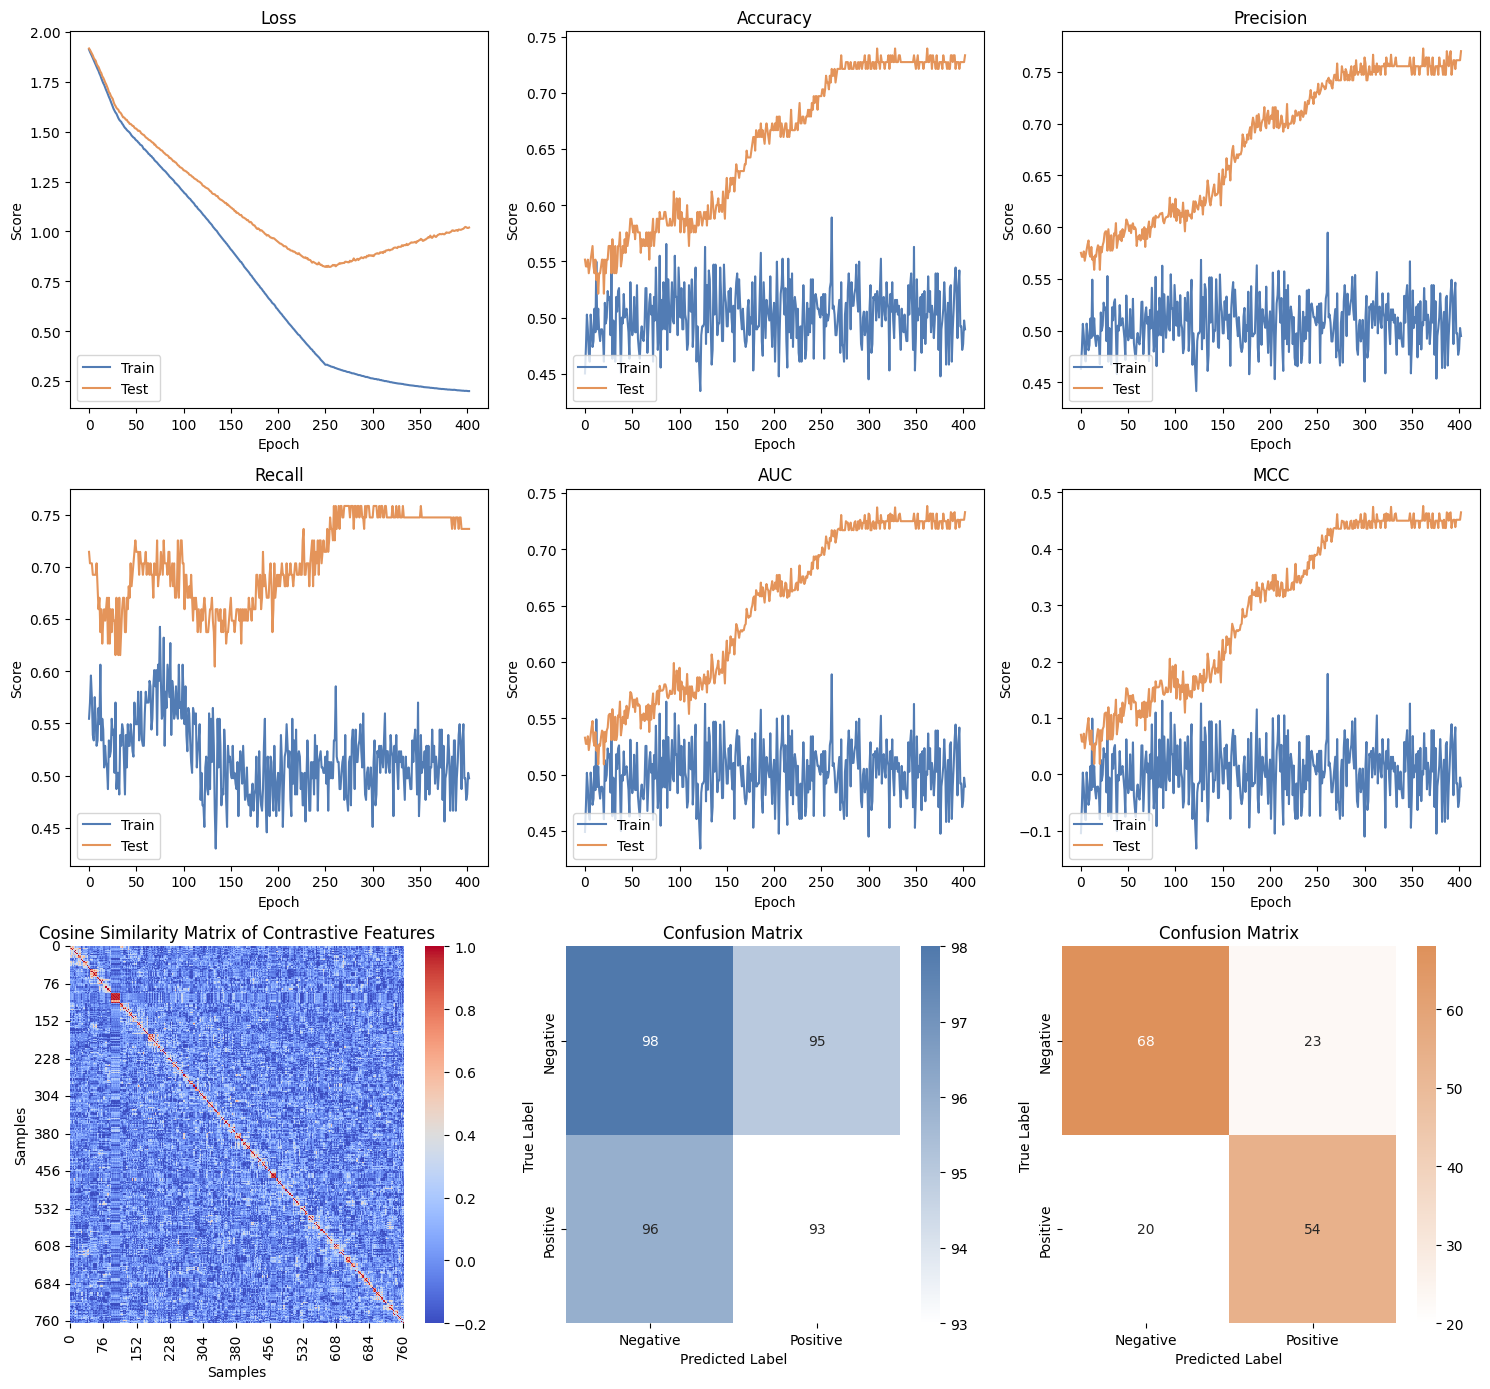

  0%|          | 1/500 [03:31<29:17:19, 211.30s/it]

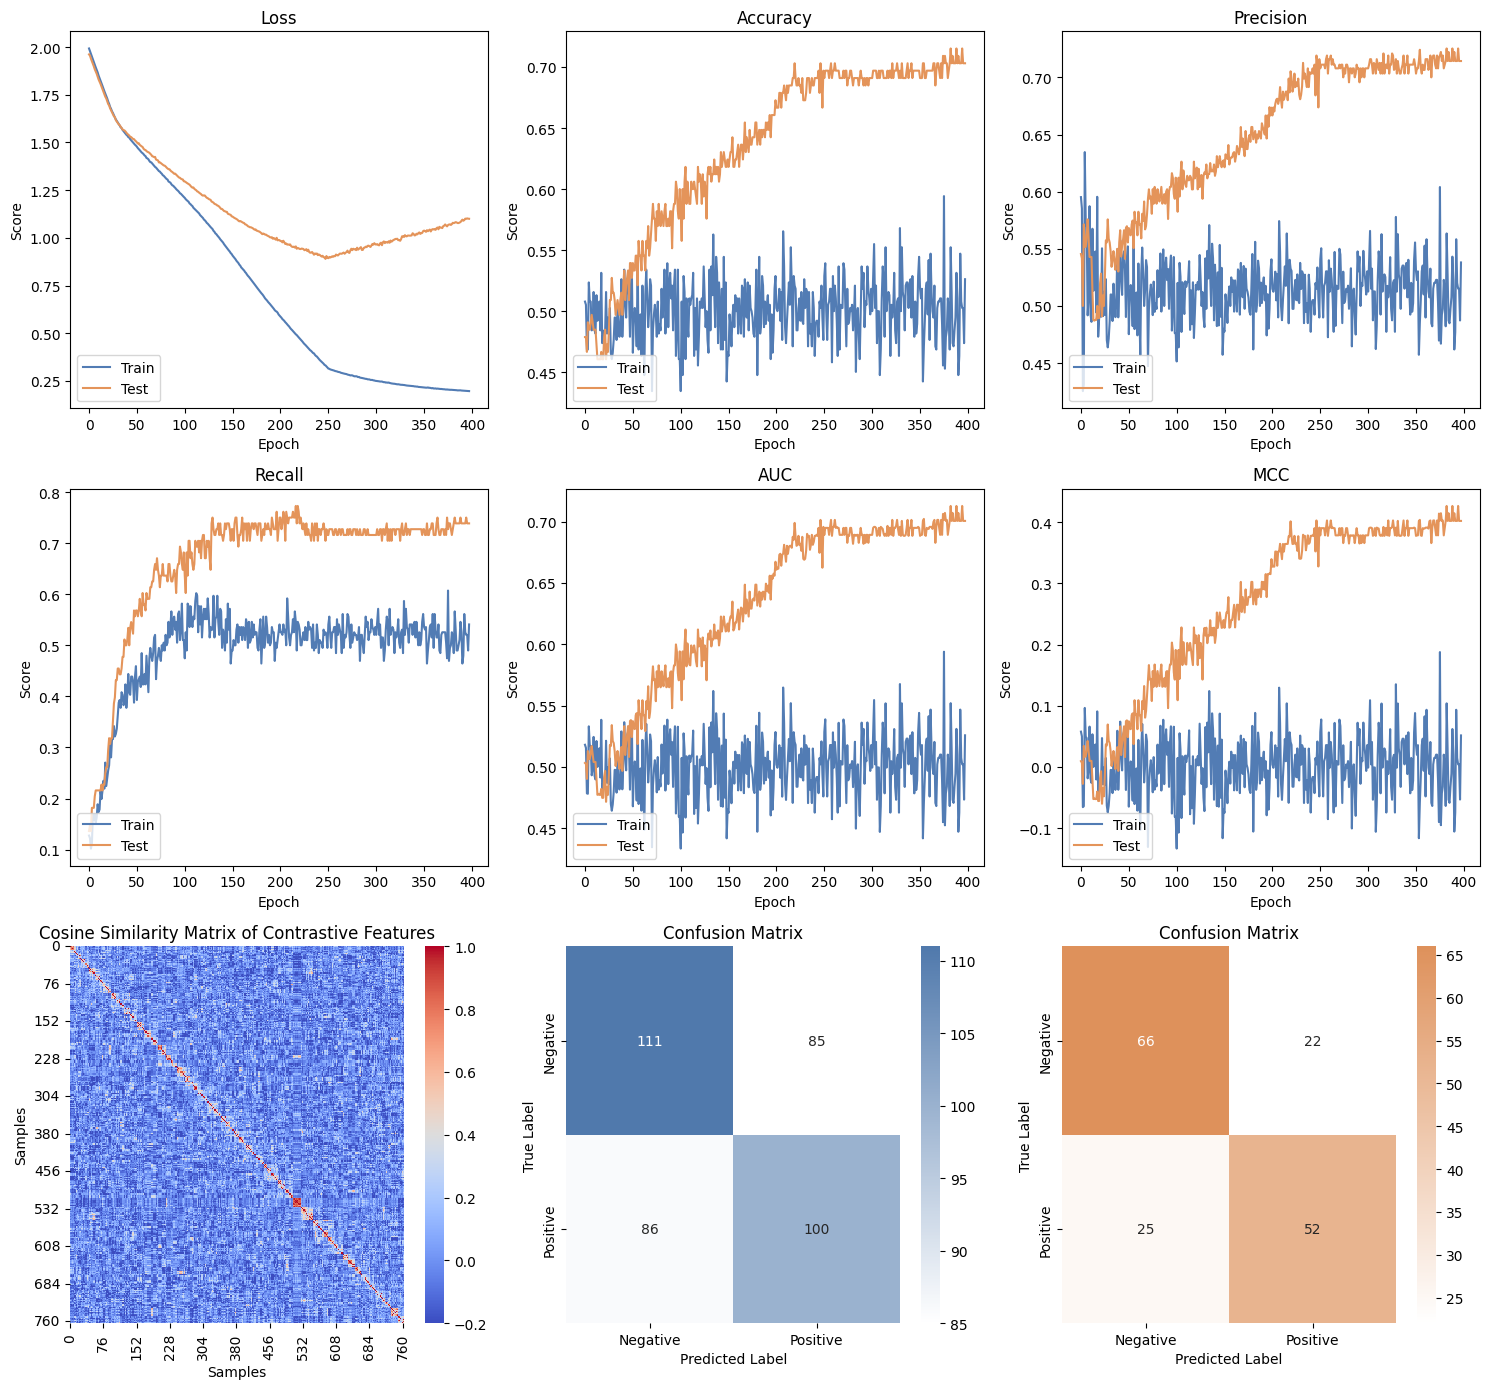

 20%|██        | 101/500 [5:52:17<23:11:44, 209.28s/it]


KeyboardInterrupt: 

In [45]:
from tqdm import tqdm
from datetime import datetime
tg_list = ['CHEMBL1811','CHEMBL1974','CHEMBL4896','CHEMBL1985']#,'CHEMBL1974','CHEMBL1985','CHEMBL4896',
#train_epochs = int(input('train_epochs = （推荐100,若想快速结束可输入个位数）'))
tg_list = [tg_list[0]]
train_epochs = 800
# 指定列名
column_names = [
    'final_index','train_best_accuracy','train_best_precision','train_best_recall','train_best_f2','train_best_loss','train_best_aucs','train_best_mccs',
                'test_best_accuracy','test_best_precision','test_best_recall','test_best_f2','test_best_loss','test_best_aucs','test_best_mccs'
]

#批次
batch_size = 64
# 定义损失函数
loss_fn = nn.CrossEntropyLoss()
# 优化器配置
l_r = 0.0001
# 定义模型
num_classes = 2  # 二分类模型[0,1]即无活性和有活性

gret_modle_data = {}
for test_num in range(0,10):#复杂度
    #复杂度为0
    test_num = 0
    print('fuzadu',test_num)
    #test_num  = 1 + test_num
    tuples_list = []
    '''开始计时'''
    start_time = datetime.now()
    for tg in tg_list:
        #靶点训练
        # 循环遍历元组列表，将每个元组添加到 DataFrame 中
        ranges = 500
        #print()
        for t in tqdm(range(ranges)):
            #print(f'第 {t+1} 次循环：')
            data_modle,best_model = train_cls(tg , train_epochs,device,test_num,batch_size,loss_fn,num_classes,l_r,t+1)
            tuples_list.append(data_modle)
            del data_modle,best_model
            #gret_modle_data[f't'] = gret_modle_data 
    # 将列表中的元组转换为 DataFrame
        df = pd.DataFrame(tuples_list, columns=column_names)
        # 将 DataFrame 保存为 CSV 文件
        df.to_csv(f'8800{tg}_{train_epochs}_{ranges}_fzd_db_{test_num}.csv',encoding='utf-8')
    end_time = datetime.now()
    # 计算循环用时
    elapsed_time = (end_time - start_time).total_seconds()
    print(f"复杂度{test_num} 用时: {elapsed_time:.6f} 秒")

In [46]:
# 将列表中的元组转换为 DataFrame
df = pd.DataFrame(tuples_list, columns=column_names)
# 将 DataFrame 保存为 CSV 文件
df.to_csv(f'8827_{tg}_{train_epochs}_{t}_fzd_db_{test_num}.csv',encoding='utf-8')